<a href="https://colab.research.google.com/gist/Balint197/6105d7ae758360b132ecc6de6d3216bb/dl-hf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up our libraries:

In [ ]:
import pathlib # for navigating folders
from pathlib import Path
import shutil
from PIL import Image # working with images
from IPython import display
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import numpy as np
from termcolor import colored # colored text
import os
from scipy import signal # working with sound
from scipy.io import wavfile
import librosa # working with sound
import librosa.display
from collections import Counter # for counting letters
import re # regexp
import requests # web scraping
from bs4 import BeautifulSoup # web scraping

content_path = Path('/').absolute() / 'content'

###1) Getting images, showing them, RGB historgram

For getting random images, I like using this library which downloads from google image search based on keywords. Install it and use it to get our images - I searched for landscapes.

In [ ]:
%cd "{content_path}"
!git clone 'https://github.com/Joeclinton1/google-images-download.git'
%cd google-images-download
!python setup.py install

!googleimagesdownload -k 'landscape' -f 'jpg' --limit '5' --output_directory '../' --image_directory 'images' --color_type 'full-color'
image_directory = content_path / 'images'

Resize the downloaded images to the desired 256x256 resolution

Note: we could also use `-es '256,256'` as a parameter for the googleimagesdownload package, but it gives boring clipart images mostly. 

In [ ]:
newsize = (256, 256)
print('resizing images...')

for input_img_path in pathlib.Path(image_directory).iterdir(): # go through files in the folder
    output_img_path = str(input_img_path) # we don't need the old images, so replace them
    with Image.open(input_img_path) as im: # open
        out = im.resize(newsize)          # resize
        out.save(output_img_path, 'PNG', dpi=(300,300)) # save image
        
print("all images resized")

resizing images...
all images resized


Show images

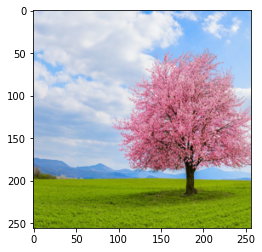

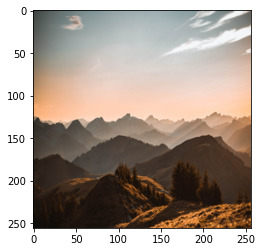

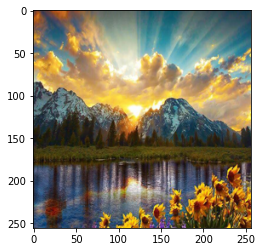

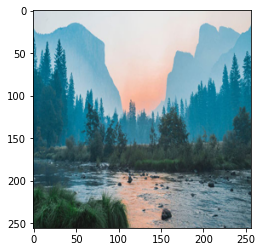

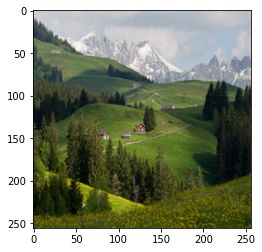

In [ ]:
for input_img_path in pathlib.Path(image_directory).iterdir():
  img = mpimg.imread(input_img_path)
  imgplot = plt.imshow(img)
  plt.show()

Show RGB channels on histogram

showing histograms for /content/images/4.lonely-japanese-cherry.jpg:


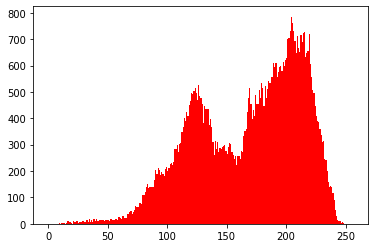

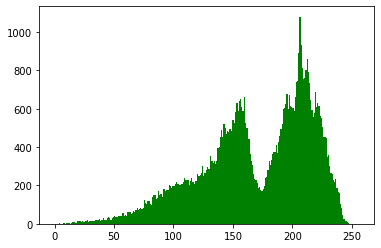

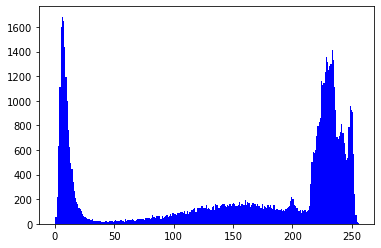

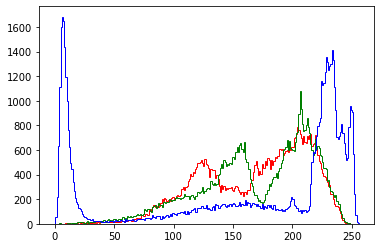

showing histograms for /content/images/5.photo-1604223190546-a43e4c7f29d7.jpg:


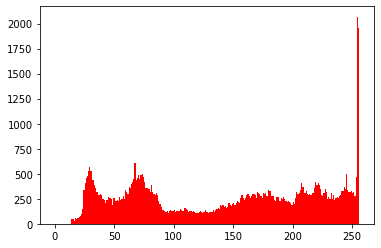

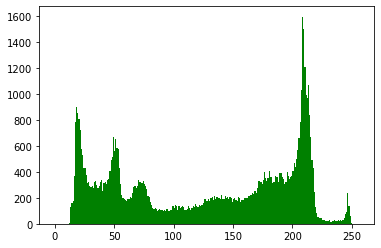

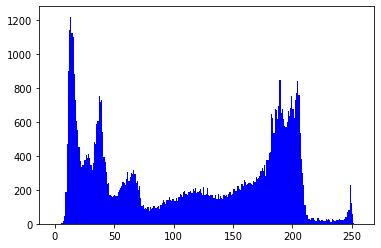

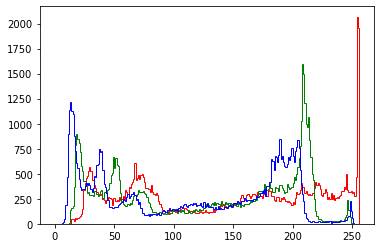

showing histograms for /content/images/3.landscape-photography-steps.jpg:


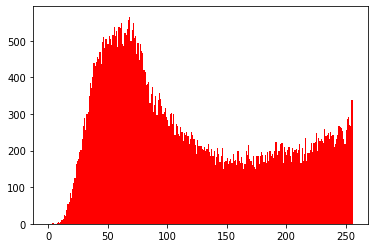

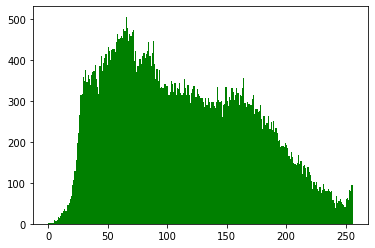

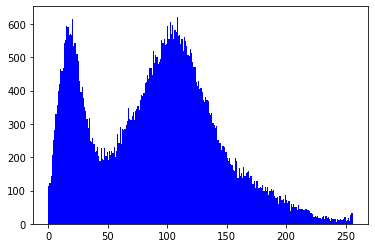

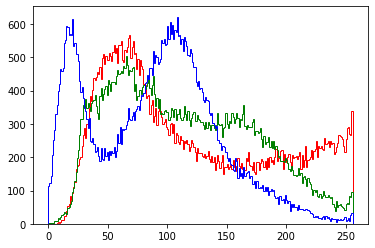

showing histograms for /content/images/1.landscape-photography-tips-yosemite-valley-feature.jpg:


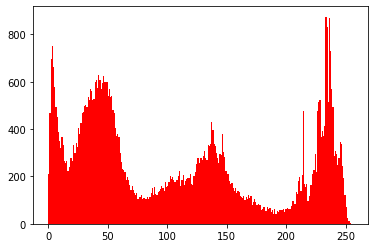

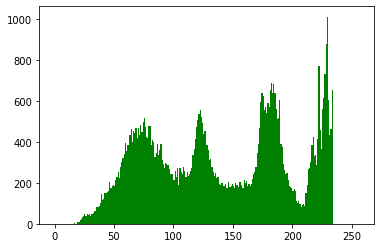

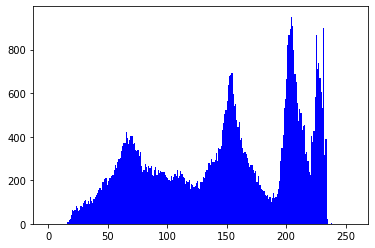

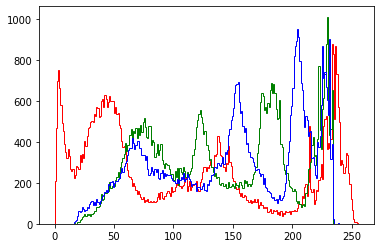

showing histograms for /content/images/2.neckertal_20150527-6384.jpg:


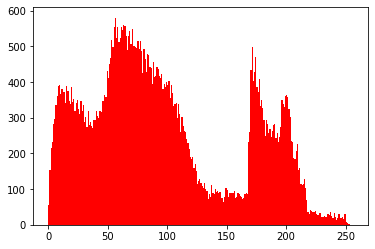

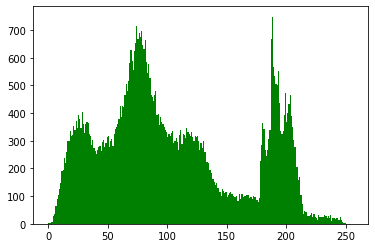

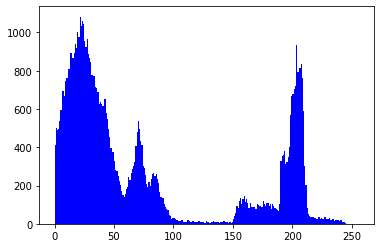

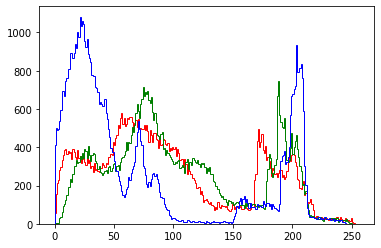

In [ ]:
colors = ['red','green','blue'] # define colors in an array, we'll use it later

for image in pathlib.Path(image_directory).iterdir():
  print("showing histograms for " + str(image) + ":")
  img = np.array(io.imread(image)) # convert image file into numpy array
  
  for color in colors: # loop through colors array
    channel=img[:,:,colors.index(color)] # get the 3rd dimension of the image, which is the color channel
    plt.hist(channel.ravel(), bins = 256, range = [0,256], color=color) # make histogram based on channel color
    plt.show()
  
  for color in colors: 
    channel=img[:,:,colors.index(color)]
    plt.hist(channel.ravel(), bins = 256, range = [0,256], color=color, histtype='step') # make histogram, but all colors are on the same chart

  plt.show()

###2) Channel data, transforming data

In [ ]:
for image in pathlib.Path(image_directory).iterdir():
  print("showing data for " + str(image) + ":")
  img = np.array(io.imread(image)) # convert image file into numpy array
  
  for color in colors:
    channeldata=img[:,:,colors.index(color)]
    print(colored(color + " channel: ",color))
    print(colored("mean: " + str(np.mean(channeldata)),color)) # calculate mean
    print(colored("std: " + str(np.std(channeldata)),color)) # calculate std
    # first, move the data 'down' with the average, so we are at 0
    # then divide by std to reduce std
    newchannel = (channeldata - np.mean(channeldata))/(np.std(channeldata))
    print(colored("new std: " + str(np.std(newchannel)),color))
    print(colored("EV: " + str(np.mean(newchannel)),color))

showing data for /content/images/4.lonely-japanese-cherry.jpg:
red channel: 
mean: 168.0821533203125
std: 44.44797546900082
new std: 1.0
EV: 0.0
green channel: 
mean: 169.28311157226562
std: 45.986984924084354
new std: 1.0
EV: 2.7755575615628914e-17
blue channel: 
mean: 158.82273864746094
std: 91.84235374050206
new std: 1.0
EV: 5.551115123125783e-17
showing data for /content/images/5.photo-1604223190546-a43e4c7f29d7.jpg:
red channel: 
mean: 144.15428161621094
std: 76.65376128368281
new std: 0.9999999999999999
EV: 8.326672684688674e-17
green channel: 
mean: 126.65065002441406
std: 72.68809708535818
new std: 1.0
EV: 5.551115123125783e-17
blue channel: 
mean: 113.11439514160156
std: 73.17111670348736
new std: 1.0
EV: 0.0
showing data for /content/images/3.landscape-photography-steps.jpg:
red channel: 
mean: 119.74942016601562
std: 69.26092718271747
new std: 1.0
EV: 1.3877787807814457e-17
green channel: 
mean: 112.94125366210938
std: 58.12641807570069
new std: 0.9999999999999999
EV: -4.163

###3,4) Get audio, show spectogram, normalise data

I used youtube-dl to extract sound from youtube videos.

In [ ]:
%pip install --upgrade youtube_dl

%cd "{content_path}"
%mkdir audio
audio_directory = content_path / 'audio'
%cd audio

# extract only audio with youtube-dl, use wav as its uncompressed, provide links to desired sounds
!youtube-dl --extract-audio --audio-format wav 'https://www.youtube.com/watch?v=qNf9nzvnd1k' 'https://www.youtube.com/watch?v=-3Jx0J6SMCc' 'https://www.youtube.com/watch?v=QceVTChhlJM' 

To work with the program creating the spectogram, we need to convert to mono:

In [ ]:
%pip install ffmpeg-python # install ffmpeg for conversion to mono
                           # we could also just use one of the channels or take their average

for mono in pathlib.Path(audio_directory).iterdir(): # loop through audio folder files
  if str(mono)[-4:] == '.wav': # sometimes there was a checkpoint file, so make sure we only work with .wav
    oldname = str(mono)
    newname = oldname[0:-4] + '_mono.wav' # give the mono files a new name (overwriting the same file with ffmpeg causes problems)
    !ffmpeg -i '{oldname}' -ac 1 '{newname}' # downmix to mono using ffmpeg
    os.remove(oldname) # delete stereo file

Create the spectrogram using librosa, a sound library:

mean: -58.149483
std:  12.842721
new mean: 4.350026e-06
new std:  0.9999995
/content/audio/Big Poppa (2007 Remaster)-QceVTChhlJM_mono.wav
mean: -52.17707
std:  14.064719
new mean: -1.6295247e-07
new std:  1.0
/content/audio/STRFKR - In The End [OFFICIAL AUDIO]--3Jx0J6SMCc_mono.wav
mean: -79.40339
std:  5.2557235
new mean: 1.5750257e-07
new std:  1.0000001
/content/audio/20Hz to 20kHz (Human Audio Spectrum)-qNf9nzvnd1k_mono.wav


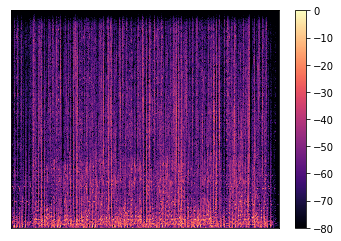

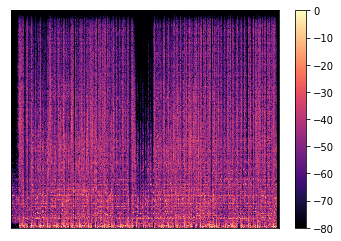

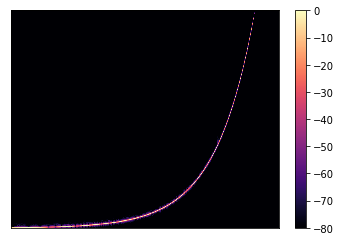

In [ ]:
for audio in pathlib.Path(audio_directory).iterdir():
  data, sr = librosa.load(audio) # load data; store data and sample rate
  D = librosa.stft(data)  # short time fourier transform of data
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # map magnitudes to decibel scale

  print("mean: " + str(np.mean(S_db)))
  print("std:  " + str(np.std(S_db)))

  # transform same was as with the images
  S_db_new = (S_db - np.mean(S_db))/(np.std(S_db))
  print("new mean: " + str(np.mean(S_db_new)))
  print("new std:  " + str(np.std(S_db_new)))

  plt.figure()
  librosa.display.specshow(S_db) # show spectrogram
  print(audio)
  plt.colorbar()

Using another package (scipy), we get worse looking results:

/content/audio/Big Poppa (2007 Remaster)-QceVTChhlJM_mono.wav


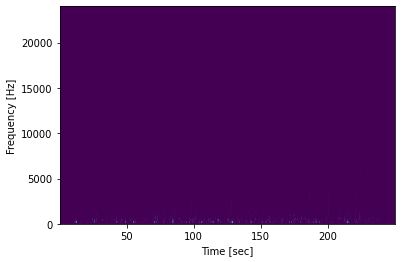

/content/audio/STRFKR - In The End [OFFICIAL AUDIO]--3Jx0J6SMCc_mono.wav


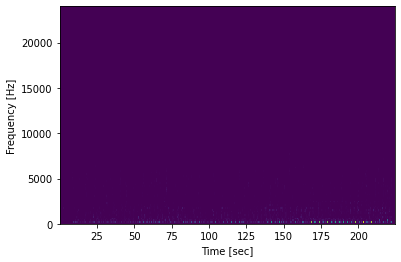

/content/audio/20Hz to 20kHz (Human Audio Spectrum)-qNf9nzvnd1k_mono.wav


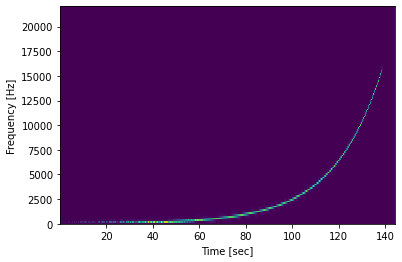

In [ ]:
for audio in pathlib.Path(audio_directory).iterdir():
    print(audio)
    sample_rate, data = wavfile.read(audio)
    frequencies, times, spectrogram = signal.spectrogram(data, sample_rate)

    plt.pcolormesh(times, frequencies, spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

###5) Web scraping

In [ ]:
URL = "http://smartlab.tmit.bme.hu/oktatas-deep-learning"
page = requests.get(URL) 
# use beautiful soup to scrape contents
soup = BeautifulSoup(page.content, "html5lib") # using html5lib instead of html.parser to fix bad html tags on site (<body>)
body = soup.find('body') # save contents of <body> tag 
text = body.get_text() # extract text from body
print(text)



    
    
        
            
            
                
            
            
            
            
                
                    
                        
                        Languages
                        
                            
                                Magyar
                            
                            English
                        
                    
                
            
            

            
            
                Menü be/kikapcsolás
                
            
            
        
		
		        
        
            
                
                    
                    
                        
                            RÓLUNK
                        
                        
							Laborunkról
							Munkatársaink
							Média megjelenések
                        
                    
                    
				
                    
                    
                        
               

There's a lot of empty space, numbers, and signs in the text, but we only need letters. So let's tidy it up a bit using regex:

In [ ]:
text = re.sub('[\s\W\d_]', '', text)
print(text)
# regex matches whitespace, digits, non-alpahnumeric characters, and `_` 
# sub substitutes matched characters with empty string

LanguagesMagyarEnglishMenübekikapcsolásRÓLUNKLaborunkrólMunkatársainkMédiamegjelenésekMEGOLDÁSAINKProfivoxmagyarnyelvűfelolvasókorpuszosProfivoxmagyarnyelvűfelolvasóDNNProfivoxmagyarnyelvűfelolvasóHMMProfivoxmagyarnyelvűfelolvasódiádostriádosStrokeAidAlkalmazásokJawsforWindowsintegrációIdőjárásmindenkinekmagyarWindowsAALFrednyelvenWindowsRobobrailleBeszélőATMekGyógyszervonalOGYIÁrlistafelolvasóTmobileKeletipályaudvarbemondórendszereMindenségelméletecfilmgépibeszédszinkronKFKutatásiprojektekfolyamatbanKutatásiprojektekbefejezettPublikációkösszesPublikációkkiemeltLetölthetőkönyvekOKTATÁSKAPCSOLATBLOGfunctionsubmitEmailvaremailemailvalvarnamenamevalvarwherewherevaljQuerypostassetsphpsendnewsphpemailemailnamenamewherewherefunctiondatasubmissionResponsehtmldatahtmlDEEPLEARNINGAGYAKORLATBANPYTHONÉSLUAALAPONKezdőlapOktatásDeepLearningHaatárgyróllecsúsztáldeszeretnéladeeplearningbebelekezdenivagymárelvégeztedatárgyatésszeretnélelmélyülniatémábanakárPhDzniakkorolvasstovábbazalábbigombrakattintv

There's some text in links before and after the "real" content we need to get rid of. I also transform everything to lowercase so `a` and `A` are considered the same letter:

In [ ]:
text = text[770:12414].lower()
print(text)

deeplearningagyakorlatbanpythonésluaalaponkezdőlapoktatásdeeplearninghaatárgyróllecsúsztáldeszeretnéladeeplearningbebelekezdenivagymárelvégeztedatárgyatésszeretnélelmélyülniatémábanakárphdzniakkorolvasstovábbazalábbigombrakattintvatovábbitudnivalókelőszörisszeretnémmegköszönniadeeplearningagyagorlatbanpythonésluaalapokontárgykereteinbelülvégzettmunkádilletveatársoktatóknakisésarengetektudástamitkaptamatőletekkapotttudásnakhálatovábbfoglalkoztamatárgyonbelülleadottházifeladatommalimuszenzorjelekfeldolgozásadeeplearningsegítségévévelésaprojekttelelnyertemasuzukifoundationösztöndíjátígyakövetkezőfélévbenjapánbankutathatokashizuokoegyetemennagybalázsbmegpkmechatronikaimérnökdoktoranduszkissgáborvagyokutolsóévesmesterképzésesmechatronikaimérnökhallgatóésbenhallgattamatárgyukatdeeplearningagyakorlatbanpythonésluaalaponaházifeladatomparancsszófelismerőneurálishálózatoktanításaésösszehasonlításavoltazértírokönöknekhogyköszönetetmondjakatárgyutánisaktívanfoglalkoztamaterülettelahogyanönökisjava

Now we have only the letters, so let's make the histogram:

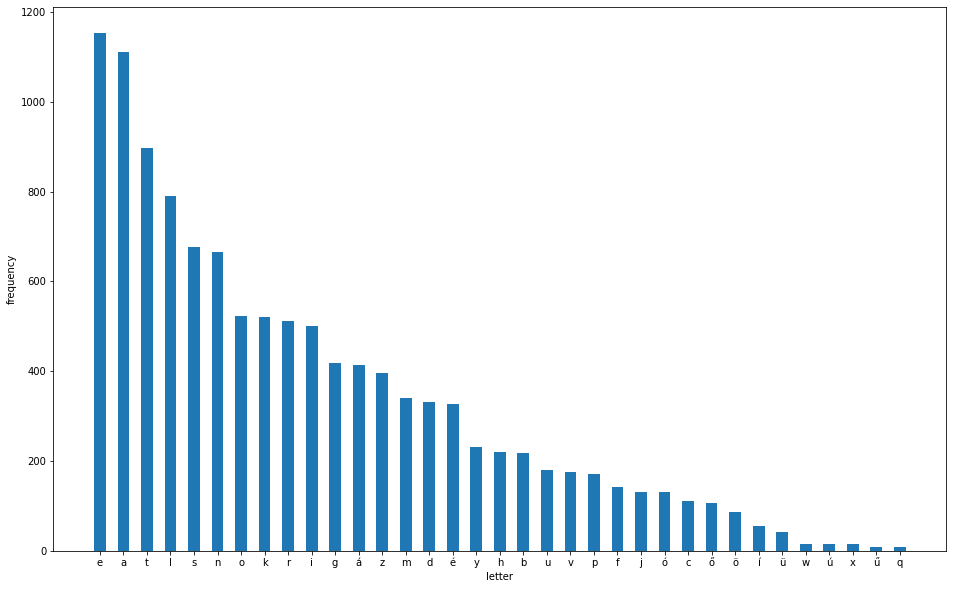

In [ ]:
counter = Counter(text) # counter creates key-value dictionary pairs between each character and their frequency
plt.figure(figsize=(16,10)) # make the image bigger
plt.xlabel('letter')
plt.ylabel('frequency')
plt.bar(*zip(*counter.most_common()), width=.5) # we take the most common elements in the counter (tuple) and pair them using zip
plt.show()